### Introduction

For the purpose of this assignment, I document the different approaches that I try to document my thought process. Theoretically, in a production setting, I would eliminate all non-essential sections.

#### Exploratory Analysis

In [1]:
%matplotlib inline
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

lt = pd.read_csv("loan_timing.csv")
lt.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


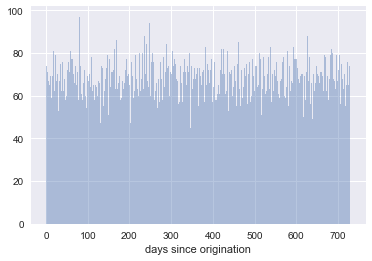

In [2]:
3305/50000

sns.distplot(lt['days since origination'], bins=731, kde=False)

The first step of a good data analysis is to improve our understanding of our data and where it comes from.

From the above, we observe the following:

1. Our oldest loan is 730 days. Since no loan is three years old, we don't have an estimate for the ratio of loans which get paid off. 

2. `days since origination` is approximately uniformally distributed, i.e. loans have been given at approximately a constant rate.



/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


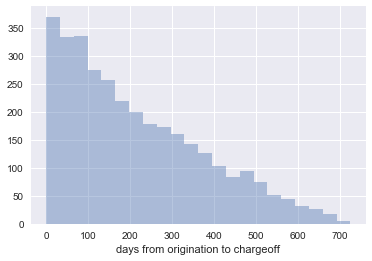

In [3]:
chargeoffs = lt.dropna() 

sns.distplot(chargeoffs['days from origination to chargeoff'], kde=False)
plt.show()

#_, counts = np.unique(chargeoffs, return_counts=True)
#print(counts)


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


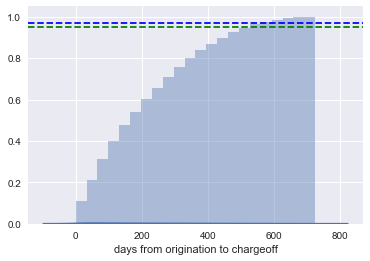

In our data, 99% of chargeoffs occur before day: 644.96


In [4]:
ax = sns.distplot(chargeoffs['days from origination to chargeoff'],
             hist_kws=dict(cumulative=True))
plt.axhline(y=.95, color="green", linestyle='--')
plt.axhline(y=.97, color="blue", linestyle='--')
plt.show()

nn_perc = np.percentile(chargeoffs['days from origination to chargeoff'], 99)
print("In our data, 99% of chargeoffs occur before day:", nn_perc)

Specifically, we see that 99% of our chargeoffs occur before day 645. Keep this in mind as we will revisit this later.

### Calculating _Survival_ and _Hazard_

A good way to account for this is to compare the chargeoffs with the number of loans that have are older than the `days from origination to chargeoff`. In essense, this will entail the calculation of the [Survival](http://mathworld.wolfram.com/SurvivalFunction.html) and [Hazard](http://mathworld.wolfram.com/HazardFunction.html) functions. In this section we will be calculating:

- The number of loans that have survived past each `day since origination` 
- The number of chargeoffs that have occured at each day.

We will represent both as `pandas.Series` objects indexed by day.


In [5]:
survivors = lt.loc[lt['days from origination to chargeoff'].isna(),:].iloc[:, 0]
print(survivors.head())

ct = Counter(survivors)
prev = 0
for i in range(max(survivors), -1, -1):
    ct.setdefault(i, 0)
    ct[i] += prev
    prev = ct[i]
    
cum_surv = pd.Series({i: ct[i] for i in sorted(ct.keys())})
print(cum_surv.iloc[:5], '\n', cum_surv.iloc[-5:])
# cum_surv.plot()

0    109
1    679
2    723
3    509
4    254
Name: days since origination, dtype: int64
0    46695
1    46642
2    46568
3    46501
4    46430
dtype: int64 
 726    294
727    239
728    184
729    122
730     61
dtype: int64


We calculate cumulative chargeoffs in a similar manner:

0    16
1    12
2    11
3     6
4    12
5    12
6    12
7    10
8    10
9     8
dtype: int64 
 721    0
722    0
723    1
724    0
725    1
726    0
727    0
728    0
729    0
730    0
dtype: int64


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


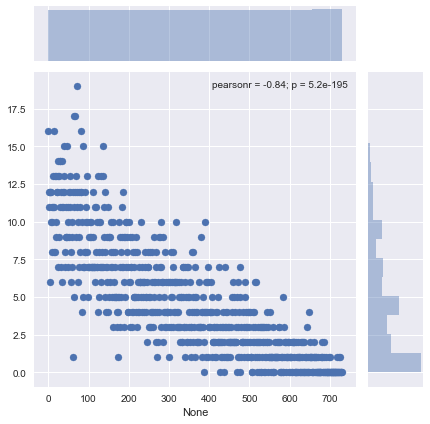

In [6]:
#asdf = chargeoffs.loc[: , 'days from origination to chargeoff'].cumsum()[::-1]
#asdf
chargeoffs['days from origination to chargeoff'].astype(int)
ct = Counter(chargeoffs['days from origination to chargeoff'])

cum_chrg = pd.Series((ct.get(i, 0) for i in cum_surv.index.values), cum_surv.index)

print(cum_chrg.iloc[:10], '\n', cum_chrg.iloc[-10:])

sns.jointplot(cum_chrg.index, cum_chrg.values)

0    0.000343
1    0.000257
2    0.000236
3    0.000129
4    0.000258
5    0.000259
6    0.000259
7    0.000216
dtype: float64 723    0.002053
724    0.000000
725    0.002825
726    0.000000
727    0.000000
728    0.000000
729    0.000000
730    0.000000
dtype: float64


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


LinregressResult(slope=-1.2180201274387583e-07, intercept=0.00022626113647962736, rvalue=-0.1505579397510616, pvalue=4.370080435141886e-05, stderr=2.9621576268081497e-08)


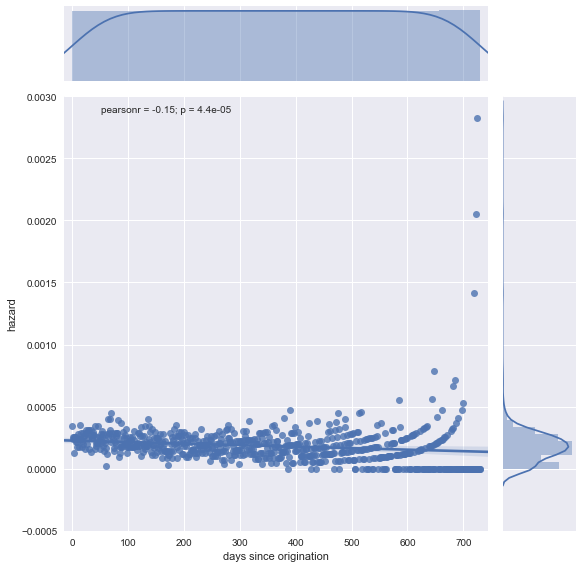

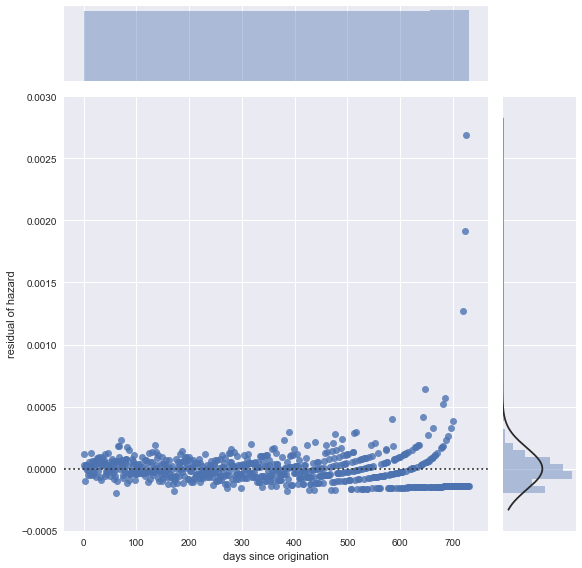

In [7]:
hazard = cum_chrg / (cum_chrg + cum_surv)
print(hazard.head(8), hazard.tail(8))

regplot = sns.jointplot(hazard.index, hazard.values, kind='reg',
                  xlim=(-14, 744), ylim=(-.0005, .003), size=8)
regplot.set_axis_labels('days since origination', 'hazard')

resid_plot = sns.jointplot(hazard.index, hazard.values, kind='resid',  
                  ylim=(-.0005, .003), size=8)
resid_plot.set_axis_labels('days since origination', 'residual of hazard')

print(stats.linregress(hazard.index.values, hazard.values))

During the first ~400 days, `hazard` seems to be approximately normally-distributed accross the residual, but begins to exhibit branching-like behavior at around day 450. This is caused by the fact that there are fewer loans this older range - each of the branches represent the number of chargebacks on the given day (zero being of course the flat one at the bottom, above which is one, followed by 2, etc.). This also explains the outliers in our graph - there are fewer loans, so a single chargebacks will have a larger numeric impact on `hazard`.

It is problematic to use the data as-is since we would be ignoring the noise generated in our data, which skews our results when we are computing a regression.

A tempting approach to resolving this issue would be to use the 99th-percentile cutoff that we calculated earlier, and ignore all loans older than 645 days. Although this allows us to retain information on 99% of our chargeofs, we would be throwing out a relatively larger percentage of our loans (`days since origination` is approximately uniformally distributed) and losing data bout their survival history. We would also be inducing an artificial scarcity of data near the 645-day cutoff, creating a circular problem.

My proposed approach is to instead calculate a weekly `hazard` rate. This would smooth our graph, thereby diminishing the data sparsity and outlier effect that we see in our oldest loans. A consequence of this decision is that our final model would predict hazard on a _weekly_ basis instead instead of a daily one; this isn't a problem since we've already seen that daily hazard is approximately linear. If a future use case needs to model daily hazard, we can still approximate it by linearly interpolating from our model.

#### Calculating Weekly Hazard


0.0    0.000249
1.0    0.000220
2.0    0.000251
3.0    0.000253
4.0    0.000249
dtype: float64 
 99.0     0.000067
100.0    0.000075
101.0    0.000000
102.0    0.000202
103.0    0.000697
dtype: float64


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


LinregressResult(slope=-8.213034729572595e-07, intercept=0.00022484972052810978, rvalue=-0.3326150836645024, pvalue=0.0005610104601197976, stderr=2.305696759277956e-07)


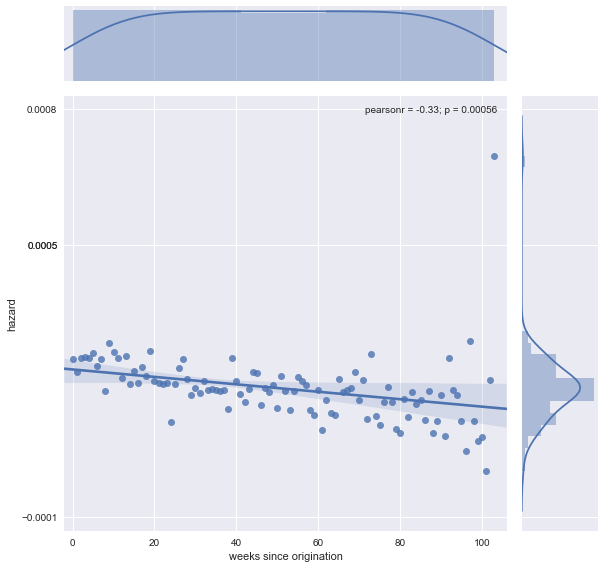

In [8]:
n_wks = 728/7
weekly_hazard = pd.Series(index=np.arange(n_wks),
                          data=(np.mean(s) for s in np.split(hazard[:728], 728/7)))
print(weekly_hazard.head(), '\n', weekly_hazard.tail())

reg_plot = sns.jointplot(weekly_hazard.index, weekly_hazard.values, kind='reg',  
                         xlim=(-2, n_wks+2), size=8)
reg_plot.ax_joint.set_yticks([-.0001, .0008, .0005, .0005])
reg_plot.set_axis_labels('weeks since origination', 'hazard')

print(stats.linregress(weekly_hazard.index, weekly_hazard.values))

As expected, our smoothing reduces the variability of `hazard` and eliminates the branching-like noise at the right hand of our graph. We see that there is a slight negative correlation between hazard and age, which matches our intuition that loans are more likely to fail earlier on in the process. 

The intercept and slope of our regression line is also pretty similar to the regression we calculated for the daily hazard rates (with x7 for the slope of course).

#### Residual Analysis of Hazard


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


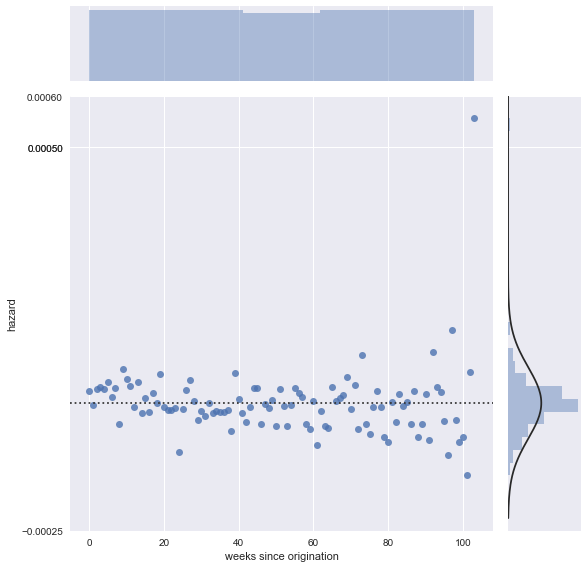

In [9]:
resid_plot = sns.jointplot(weekly_hazard.index, weekly_hazard.values, kind='resid',  
                           ylim=(-.00025, .0006), size=8)
resid_plot.ax_joint.set_yticks([-.00025, .0006, .0005, .0005])
resid_plot.set_axis_labels('weeks since origination', 'hazard')


In [10]:
slope, intercept, *_ = stats.linregress(weekly_hazard.index, weekly_hazard.values)

resid = weekly_hazard.values - intercept - slope*weekly_hazard.index
print('The Pearson correlation coefficient of our residual is:', stats.pearsonr(weekly_hazard.index, resid)[0])

The Pearson correlation coefficient of our residual is: 3.179137816374976e-17


There is approximately 0 correlation between the residual and `weeks since origination`. We also observe from our marginal that the residual is approximately Normally distributed. Both of these indicate that it would be appropriate to model `hazard` has a linear function with respect to time.

#### Building a Hazard Model

Usually, when building a model, we would split our data into training, test, and cross-validation sets. In this case, it's pretty evident that we are neither underfitting nor overfitting so this is unneccessary. We can just move forward with our current data.

#### Survivorship Estimation

Using the information that we have (i.e. number of loans for each `day since origination` and interpolated daily hazard rate), we can calculate an expected value for the number of final survivors. This can be done mathematically, but in this situation doing a Monte Carlo method would may eventually prove more useful since we can get information about the variance (i.e. confidence interval) of survivorship.

A single iteration of our algorithm can be boiled down into a single matrix multiplication applied to a vector of survivor counts. First, we should calculate daily hazard rates by interpolating our linear regression:


In [11]:
daily_hazard = np.fromiter((intercept + i*slope/7 for i in range(3*365)), float)

print(daily_hazard[:5], '\n', daily_hazard[-5:], '\n', len(daily_hazard))

[0.00022485 0.00022473 0.00022462 0.0002245  0.00022438] 
 [9.69610369e-05 9.68437078e-05 9.67263787e-05 9.66090497e-05
 9.64917206e-05] 
 1095


And next we calculate a count of our survivors:

In [12]:
survivors = lt.loc[lt.loc[:, 'days from origination to chargeoff'].isna(), 'days since origination']
print(survivors.head(), len(survivors))

ct = Counter(survivors)

surv_vector = np.fromiter((ct.get(i, 0) for i in range(3*365 + 1)), float)
print (surv_vector, len(surv_vector), sum(surv_vector))

0    109
1    679
2    723
3    509
4    254
Name: days since origination, dtype: int64 46695
[53. 74. 67. ...  0.  0.  0.] 1096 46695.0


This matrix represents a calculation of one day's survivorship:

In [13]:
sim = np.eye(3*365+1, k=1)
sim[-1, -1] = 1
for i, hazard in enumerate(daily_hazard):
    sim[i, i+1] -= hazard

print(sim, sim.shape)

[[0.         0.99977515 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99977527 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.99990339 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99990351]
 [0.         0.         0.         ... 0.         0.         1.        ]] (1096, 1096)


Finally, we perform a matrix multiplication to see the final result:

In [34]:
projected_surv = np.matmul(surv_vector, np.linalg.matrix_power(sim, 3*365))[-1]
print(projected_surv)

42049.7956750627


Thus, our final expected value is 42050 survivors. 

We can get a confience interval of our data using Montecarlo methods, with essentially the same steps as above. 

In [16]:
n_trials = 100
trial_results = []

for i in range(n_trials):
    curr = surv_vector
    for j in range(3*365):
        next = np.array([0] + [np.random.binomial(surv, 1-hazard) 
                               for surv, hazard in zip(curr, daily_hazard)])
        next[-1] += curr[-1]
        curr = next
    final_survs = curr[-1]
    trial_results.append(final_survs)

print(trial_results)


[42039, 41957, 42033, 42046, 42126, 42067, 41985, 42027, 42003, 41917, 42133, 41987, 42039, 42016, 42092, 42129, 42136, 42151, 42078, 42062, 42075, 42091, 42069, 42027, 41906, 42049, 42052, 41989, 42071, 42061, 41956, 42032, 42018, 42035, 42086, 41951, 42044, 42071, 42125, 41985, 41957, 41939, 42051, 42029, 42000, 42092, 41988, 42011, 41886, 42071, 41996, 42080, 42244, 42158, 42168, 41999, 42077, 41968, 42054, 42090, 42120, 42052, 41918, 42072, 42085, 42046, 42174, 42097, 42095, 42154, 42080, 41988, 42078, 42054, 42146, 42090, 42074, 42160, 42172, 42136, 42086, 42061, 42148, 42094, 41959, 42132, 42009, 42048, 42006, 41948, 42111, 41988, 42077, 42132, 42023, 41923, 42088, 42010, 42222, 42090]


In [ ]:
print(np.mean(trial_results))
print(np.std(trial_results))

sns.distplot(trial_results)

As we increase `n_trials`, our sample standard deviation `np.std(trial_results)` will approach the actual standard deviation of survivorship.

We expect our simulation of survivorship to be approximately normal since our methodology is essentially a sum of binomial distributions, and binomial distributions are approximately normally distributed for large `n`.

##### Numeric Computation of Standard Deviation

The numeric computation for standard deviation of survivorship is pretty involved since it is the convolution of independent binomial random distributions. We have already calculated the parameters `n` and `p` for each of these distributions:


In [28]:
probs = np.linalg.matrix_power(sim, 3*365)[:731, -1]
print(surv_vector[:10])
print(probs[:10])

[53. 74. 67. 71. 77. 67. 76. 47. 65. 67.]
[0.83866048 0.83884909 0.83903765 0.83922616 0.8394146  0.83960299
 0.83979133 0.83997961 0.84016783 0.84035599]


Methodology for this calculation is available here: https://link.springer.com/article/10.1007/s11009-016-9533-4 but I'll omit the implementation.

### Final Result

The final ratio of chargeoffs is approximately:

In [36]:
1 - projected_surv / sum(surv_vector) 

0.09947969429140813

So approximately 9.95% of current loans will charge off. If we use additional computing power (via. the Montecarlo setup above) or mathematical work (via. convolution formula), we can improve our understanding of this prediction by computing a confidence interval for survivorship.
